# LINCS L1000 Gene-Gene edges

In [1]:
import json
import os
import itertools
import random

import pandas
import requests
import scipy.stats
import numpy
import matplotlib.pyplot
import seaborn

%matplotlib inline

/home/dhimmels/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/dhimmels/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Entrez Gene

Read the gene symbol/synonym to entrez_gene_id mapping.

In [2]:
url = 'https://github.com/dhimmel/entrez-gene/raw/a7362748a34211e5df6f2d185bb3246279760546/data/symbol-map.json'
symbol_map = json.loads(requests.get(url).text)

## LINCS L1000

In [3]:
def get_bonferroni_z_cutoff(n, alpha=0.05):
    """Get a two-tailed Bonferroni z-score cutoff"""
    return scipy.stats.norm.ppf(1 - alpha / n / 2) 

In [4]:
def process_matrix(matrix_df, pertubagen_type=str):
    z_cutoff = get_bonferroni_z_cutoff(len(matrix_df.columns))
    matrix_df.index.name = 'perturbagen'
    melt_df = pandas.melt(matrix_df.reset_index(), id_vars='perturbagen', var_name='entrez_gene_id', value_name='z_score')
    melt_df.perturbagen = melt_df.perturbagen.astype(pertubagen_type)
    melt_df['direction'] = 'none'
    melt_df.loc[melt_df.z_score <= -z_cutoff, 'direction'] = 'down'
    melt_df.loc[melt_df.z_score >= z_cutoff, 'direction'] = 'up'
    #melt_df = melt_df.query("direction != 'none'")
    melt_df = melt_df.sort_values(['perturbagen', 'z_score'])
    return melt_df

### DrugBank perturbagens

In [5]:
path = os.path.join('data', 'consensi', 'consensi-drugbank.tsv.gz')
l1000_df = pandas.read_table(path, index_col=0, compression='gzip')
l1000_df.head(2)

,10007,1001,10013,10038,10046,10049,10051,10057,10058,10059,...,9918,9924,9926,9928,993,994,9943,9961,998,9988
perturbagen,,,,,,,,,,,,,,,,,,,,,
DB00014,0.649,-1.952,-0.133,1.057,0.556,-0.983,0.552,1.179,0.520,-0.741,...,-0.453,0.336,0.211,1.084,0.879,-0.311,0.334,-1.175,-0.560,-0.128
DB00091,-4.878,2.527,10.730,-2.106,-0.396,0.994,-11.172,2.177,1.137,-9.118,...,-3.132,10.105,1.223,-9.263,-10.680,-6.419,-4.387,-1.646,-5.403,6.926


In [6]:
db_df = process_matrix(l1000_df)
db_df.head(2)

,perturbagen,entrez_gene_id,z_score,direction
152100,DB00014,128,-3.156,none
668070,DB00014,5529,-3.098,none


In [7]:
db_diffex_df = db_df.query("direction != 'none'")
path = os.path.join('data', 'consensi', 'binary', 'consensi-drugbank-binary.tsv')
db_diffex_df.to_csv(path, index=False, sep='\t')
db_diffex_df.direction.value_counts()

down    34560
up      30280
Name: direction, dtype: int64

## Gene interference

### Knockdowns

In [8]:
path = os.path.join('data', 'consensi', 'consensi-knockdown.tsv.gz')
l1000_kd_df = pandas.read_table(path, index_col=0, compression='gzip')
l1000_kd_df = l1000_kd_df.groupby(symbol_map).mean()
l1000_kd_df.head(2)

,10007,1001,10013,10038,10046,10049,10051,10057,10058,10059,...,9918,9924,9926,9928,993,994,9943,9961,998,9988
2,0.649,-0.248,-0.295,2.186,2.914,-3.642,1.963,0.603,1.513,0.575,...,-3.001,0.948,0.967,0.780,2.605,1.947,3.807,1.942,0.849,-0.613
9,0.071,-1.288,0.403,-1.694,4.101,1.107,0.541,-0.414,0.472,-2.552,...,-0.489,-1.707,1.534,-0.024,0.686,-2.716,1.706,-1.048,-0.024,0.206


In [9]:
l1000_kd_df.shape

(4326, 978)

In [10]:
kd_df = process_matrix(l1000_kd_df, pertubagen_type=int)
kd_df.head(2)

,perturbagen,entrez_gene_id,z_score,direction
1345386,2,27032,-7.437,down
1418928,2,2886,-7.407,down


In [11]:
kd_diffex_df = kd_df.query("direction != 'none'")
path = os.path.join('data', 'consensi', 'binary', 'consensi-knockdown-binary.tsv')
kd_diffex_df.to_csv(path, index=False, sep='\t')
kd_diffex_df.direction.value_counts()

down    140358
up       77529
Name: direction, dtype: int64

## Overexpressions

In [12]:
path = os.path.join('data', 'consensi', 'consensi-overexpression.tsv.gz')
l1000_oe_df = pandas.read_table(path, index_col=0, compression='gzip')
l1000_oe_df = l1000_oe_df.groupby(symbol_map).mean()
l1000_oe_df.head(2)

,10007,1001,10013,10038,10046,10049,10051,10057,10058,10059,...,9918,9924,9926,9928,993,994,9943,9961,998,9988
2,0.284,-0.606,-0.382,1.000,-1.098,1.174,-0.230,-0.340,-0.003,0.249,...,-0.031,1.540,-1.100,0.077,0.424,-0.480,-0.394,-0.945,-0.324,0.210
9,0.911,-1.141,1.293,1.144,0.304,-0.919,-0.333,-0.233,0.359,0.341,...,-1.480,0.252,0.974,1.800,0.920,0.637,0.639,0.781,0.550,0.371


In [13]:
l1000_oe_df.shape

(2413, 978)

In [14]:
oe_df = process_matrix(l1000_oe_df, pertubagen_type=int)
oe_df.head(2)

,perturbagen,entrez_gene_id,z_score,direction
2328545,2,991,-4.687,down
1831467,2,7159,-3.963,none


In [15]:
oe_diffex_df = oe_df.query("direction != 'none'")
path = os.path.join('data', 'consensi', 'binary', 'consensi-overexpression-binary.tsv')
oe_diffex_df.to_csv(path, index=False, sep='\t')
oe_diffex_df.direction.value_counts()

up      15345
down    14962
Name: direction, dtype: int64

## Compare knockdowns and overexpressions

In [16]:
# Find genes with both a knockdown and overexpression signature
overlapping_genes = sorted(set(l1000_kd_df.index.map(int)) & set(l1000_oe_df.index.map(int)))

In [17]:
def get_corr(knockeddown_gene, overexpressed_gene):
    """Find the Spearman's correlation of a knockdown signature and an overexpression signature"""
    knockdown_signature = l1000_kd_df.loc[knockeddown_gene, :]
    overexpression_signature = l1000_oe_df.loc[overexpressed_gene, :]
    return knockdown_signature.corr(overexpression_signature, method='spearman')

rows = list()

for gene in overlapping_genes:
    row = gene, gene, 'Same Genes', get_corr(gene, gene)
    rows.append(row)

control_pairs = list(itertools.combinations(overlapping_genes, 2))
control_pairs = random.sample(control_pairs, k=4 * len(overlapping_genes))
for gene_kd, gene_oe in control_pairs:
    row = gene_kd, gene_oe, 'Different Genes', get_corr(gene_kd, gene_oe)
    rows.append(row)

corr_df = pandas.DataFrame(rows, columns = ('knockdown', 'overexpression', 'kind', 'spearman'))

In [18]:
corr_df.head(2)

,knockdown,overexpression,kind,spearman
0,2,2,Same Genes,-0.346204
1,9,9,Same Genes,-0.026034


In [19]:
corr_df.tail(2)

,knockdown,overexpression,kind,spearman
10018,3221,125965,Different Genes,0.348424
10019,2189,7052,Different Genes,0.010353


In [20]:
seaborn.set(style='whitegrid')
seaborn.set_style({'figure.figsize': (5, 2)})

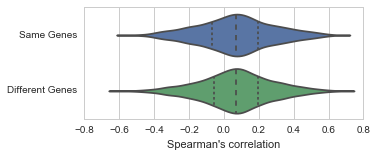

In [21]:
ax = seaborn.violinplot(x='spearman', y='kind', data=corr_df, inner='quartile')
text = ax.set_xlabel("Spearman's correlation")
text = ax.set_ylabel('')
matplotlib.pyplot.savefig('viz/knockdown-overexpression-corr.png', bbox_inches='tight', cut=0)

In [22]:
# Percent of correlations that are positive
100 * corr_df.groupby('kind').spearman.apply(lambda x: (x > 0).mean())

kind
Different Genes    65.256986
Same Genes         65.019960
Name: spearman, dtype: float64

### Compare knockdowns and overexpressions using perturbagen-gene pairs as observations

In [23]:
kd_df = kd_df.rename(columns = {'z_score': 'z_score_kd', 'direction': 'direction_kd'})
oe_df = oe_df.rename(columns = {'z_score': 'z_score_oe', 'direction': 'direction_oe'})
merged_df = kd_df.merge(oe_df)
signif_df = merged_df.query("direction_kd != 'none' or (direction_oe != 'none')")
double_df = merged_df.query("direction_kd != 'none' and (direction_oe != 'none')")
len(signif_df), len(double_df)

(133670, 2235)

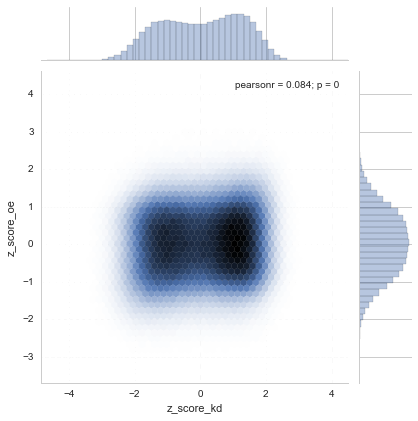

In [24]:
# Comparing overexpression versus knockdown of the same gene
grid = seaborn.jointplot(numpy.arcsinh(merged_df.z_score_kd), numpy.arcsinh(merged_df.z_score_oe), kind='hex', gridsize=50)

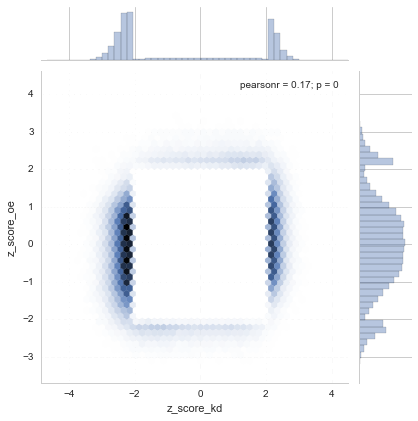

In [25]:
# Comparing overexpression versus knockdown of the same gene
# Filtering for significant up or down-regulation
grid = seaborn.jointplot(numpy.arcsinh(signif_df.z_score_kd), numpy.arcsinh(signif_df.z_score_oe), kind='hex', gridsize=50)

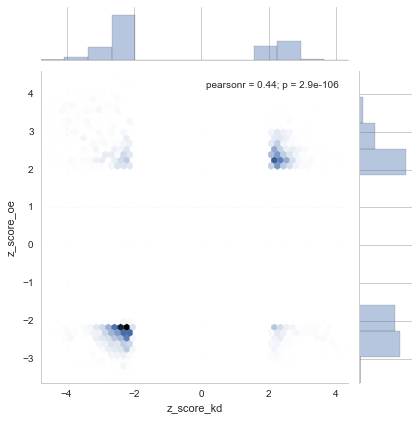

In [26]:
# Comparing overexpression versus knockdown of the same gene
# Filtering for significant up and down-regulation
grid = seaborn.jointplot(numpy.arcsinh(double_df.z_score_kd), numpy.arcsinh(double_df.z_score_oe), kind='hex', gridsize=50)

In [27]:
# Counts (overexpression as columns, knockdowns as rows)
table = pandas.crosstab(merged_df.direction_kd, merged_df.direction_oe)
table

direction_oe,down,none,up
direction_kd,,,
down,1039,69379,368
none,11289,1826242,11502
up,164,39265,664


In [28]:
# Counts as percentages (overexpression as columns, knockdowns as rows)
(100 * table / table.sum().sum()).round(3)

,down,none,up
direction_kd,,,
down,0.053,3.540,0.019
none,0.576,93.180,0.587
up,0.008,2.003,0.034


In [29]:
# Columns sum to 100
(100 * table.divide(table.sum(0), axis=1)).round(3)

,down,none,up
direction_kd,,,
down,8.317,3.586,2.936
none,90.370,94.385,91.766
up,1.313,2.029,5.298


In [30]:
# Rows sum to 100
(100 * table.divide(table.sum(1), axis=0)).round(3)

,down,none,up
direction_kd,,,
down,1.468,98.012,0.520
none,0.611,98.767,0.622
up,0.409,97.935,1.656
